In [5]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

In [6]:
ROOT_PATH = "../../results/1744992824"

min_results_path = f"{ROOT_PATH}/min_top_category_usage_group_500_200_10_0_0.35_0.7_1_0.95.json"
mean_results_path = f"{ROOT_PATH}/mean_top_category_usage_group_500_200_10_0_0.35_0.7_1_0.95.json"
cvar_results_path = f"{ROOT_PATH}/cvar_top_category_usage_group_500_200_10_0_0.35_0.7_1_0.95.json"

with open(min_results_path, "r") as f:
    min_results = json.load(f)

with open(mean_results_path, "r") as f:
    mean_results = json.load(f)

with open(cvar_results_path, "r") as f:
    cvar_results = json.load(f)

In [7]:
def plot_methods_results_per_gamma(
    all_results: dict[str, dict],
    groups_key: str,
    n_consumers: int,
    n_producers: int,
    n_runs: int,
    k_rec: int,
    save_path,
) -> None:
    sns.set_style("whitegrid")
    n_methods = len(all_results)
    fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods+2, 5), dpi=300)
    if n_methods == 1:
        axes = [axes]
    palette = sns.color_palette("colorblind", len(next(iter(all_results.values())).keys()))
    sns.set_palette(palette)

    for ax, (method_name, results) in zip(axes, all_results.items()):
        z = 1
        max_z = len(results)
        for group_name, group_results in results.items():
            alpha, alpha_results = next(iter(group_results.items()))
            xs, ys, ye = [], [], []
            for gamma, runs in sorted(alpha_results.items()):
                run_means = [np.mean(run) for run in runs]
                xs.append(gamma)
                ys.append(np.mean(run_means))
                ye.append(np.std(run_means) / np.sqrt(len(runs)))

            if group_name == "all":
                ax.plot(xs, ys, color="black", linestyle="--", marker="s", markersize=4,
                        zorder=max_z, label="Mean")
            else:
                ax.plot(xs, ys, label=group_name.replace("_", " ").capitalize(),
                        marker=".", markersize=4, zorder=z)
                ax.fill_between(xs, np.array(ys)-np.array(ye), np.array(ys)+np.array(ye),
                                alpha=0.05, zorder=z)
                z += 1

        ax.set_title(method_name.replace("_", " "))

    # centered x‑label
    fig.supxlabel(
        r"Fraction of best min producer utility guaranteed, $\gamma$",
        x=0.5, y=0.02, ha="center"
    )
    # shift the y‑label further left by lowering x
    fig.supylabel(
        "Normalized consumer utility",
        x=0.01,      # smaller x pushes it further out
        ha="center"  # center it vertically
    )

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Groups",
               loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, markerscale=0)

    fig.tight_layout(rect=[0, 0, 1, 0.90])
    # centered title
    fig.suptitle(
        f'Consumer–Producer Utility Tradeoff',
        x=0.5, y=0.95
    )

    filename = f"results_per_gamma_{groups_key}_{n_consumers}_{n_producers}_{n_runs}_{k_rec}.pdf"

    save_path.mkdir(parents=True, exist_ok=True)

    plt.savefig(save_path / filename, bbox_inches="tight")


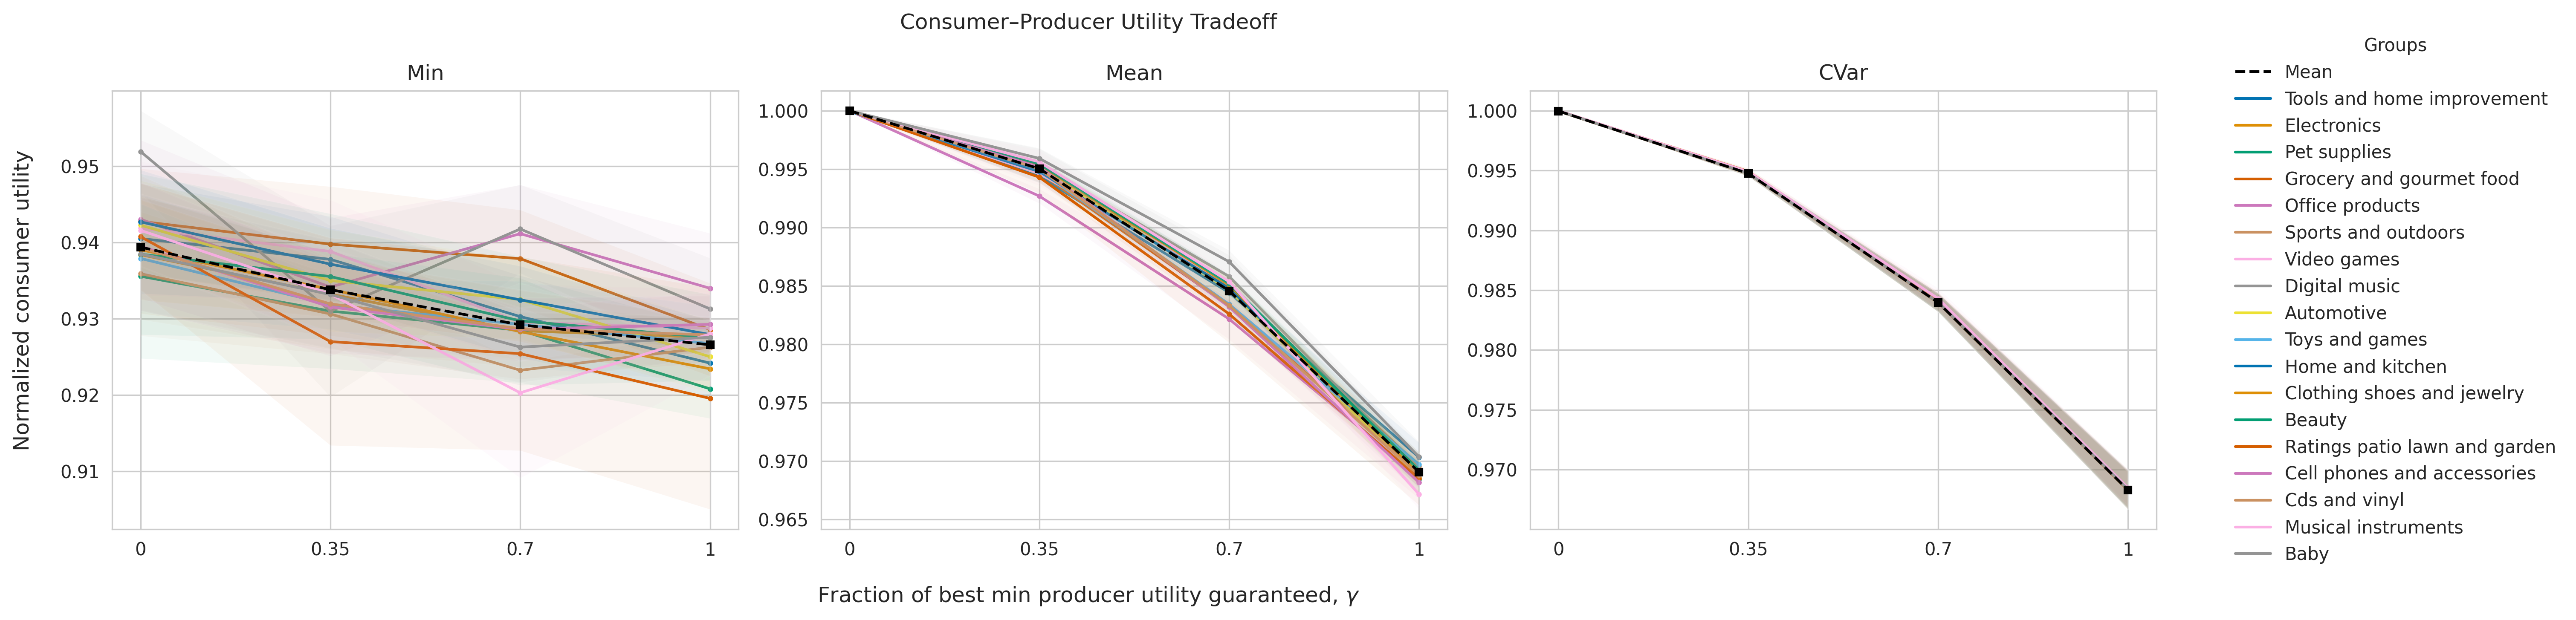

In [8]:
plot_methods_results_per_gamma(
    {
        "Min": min_results["results"]["top_category"],
        "Mean": mean_results["results"]["top_category"],
        "CVar": cvar_results["results"]["top_category"],
    },
    "top_category",
    n_consumers=500,
    n_producers=200,
    n_runs=5,
    k_rec=10,
    save_path=Path("results")
)

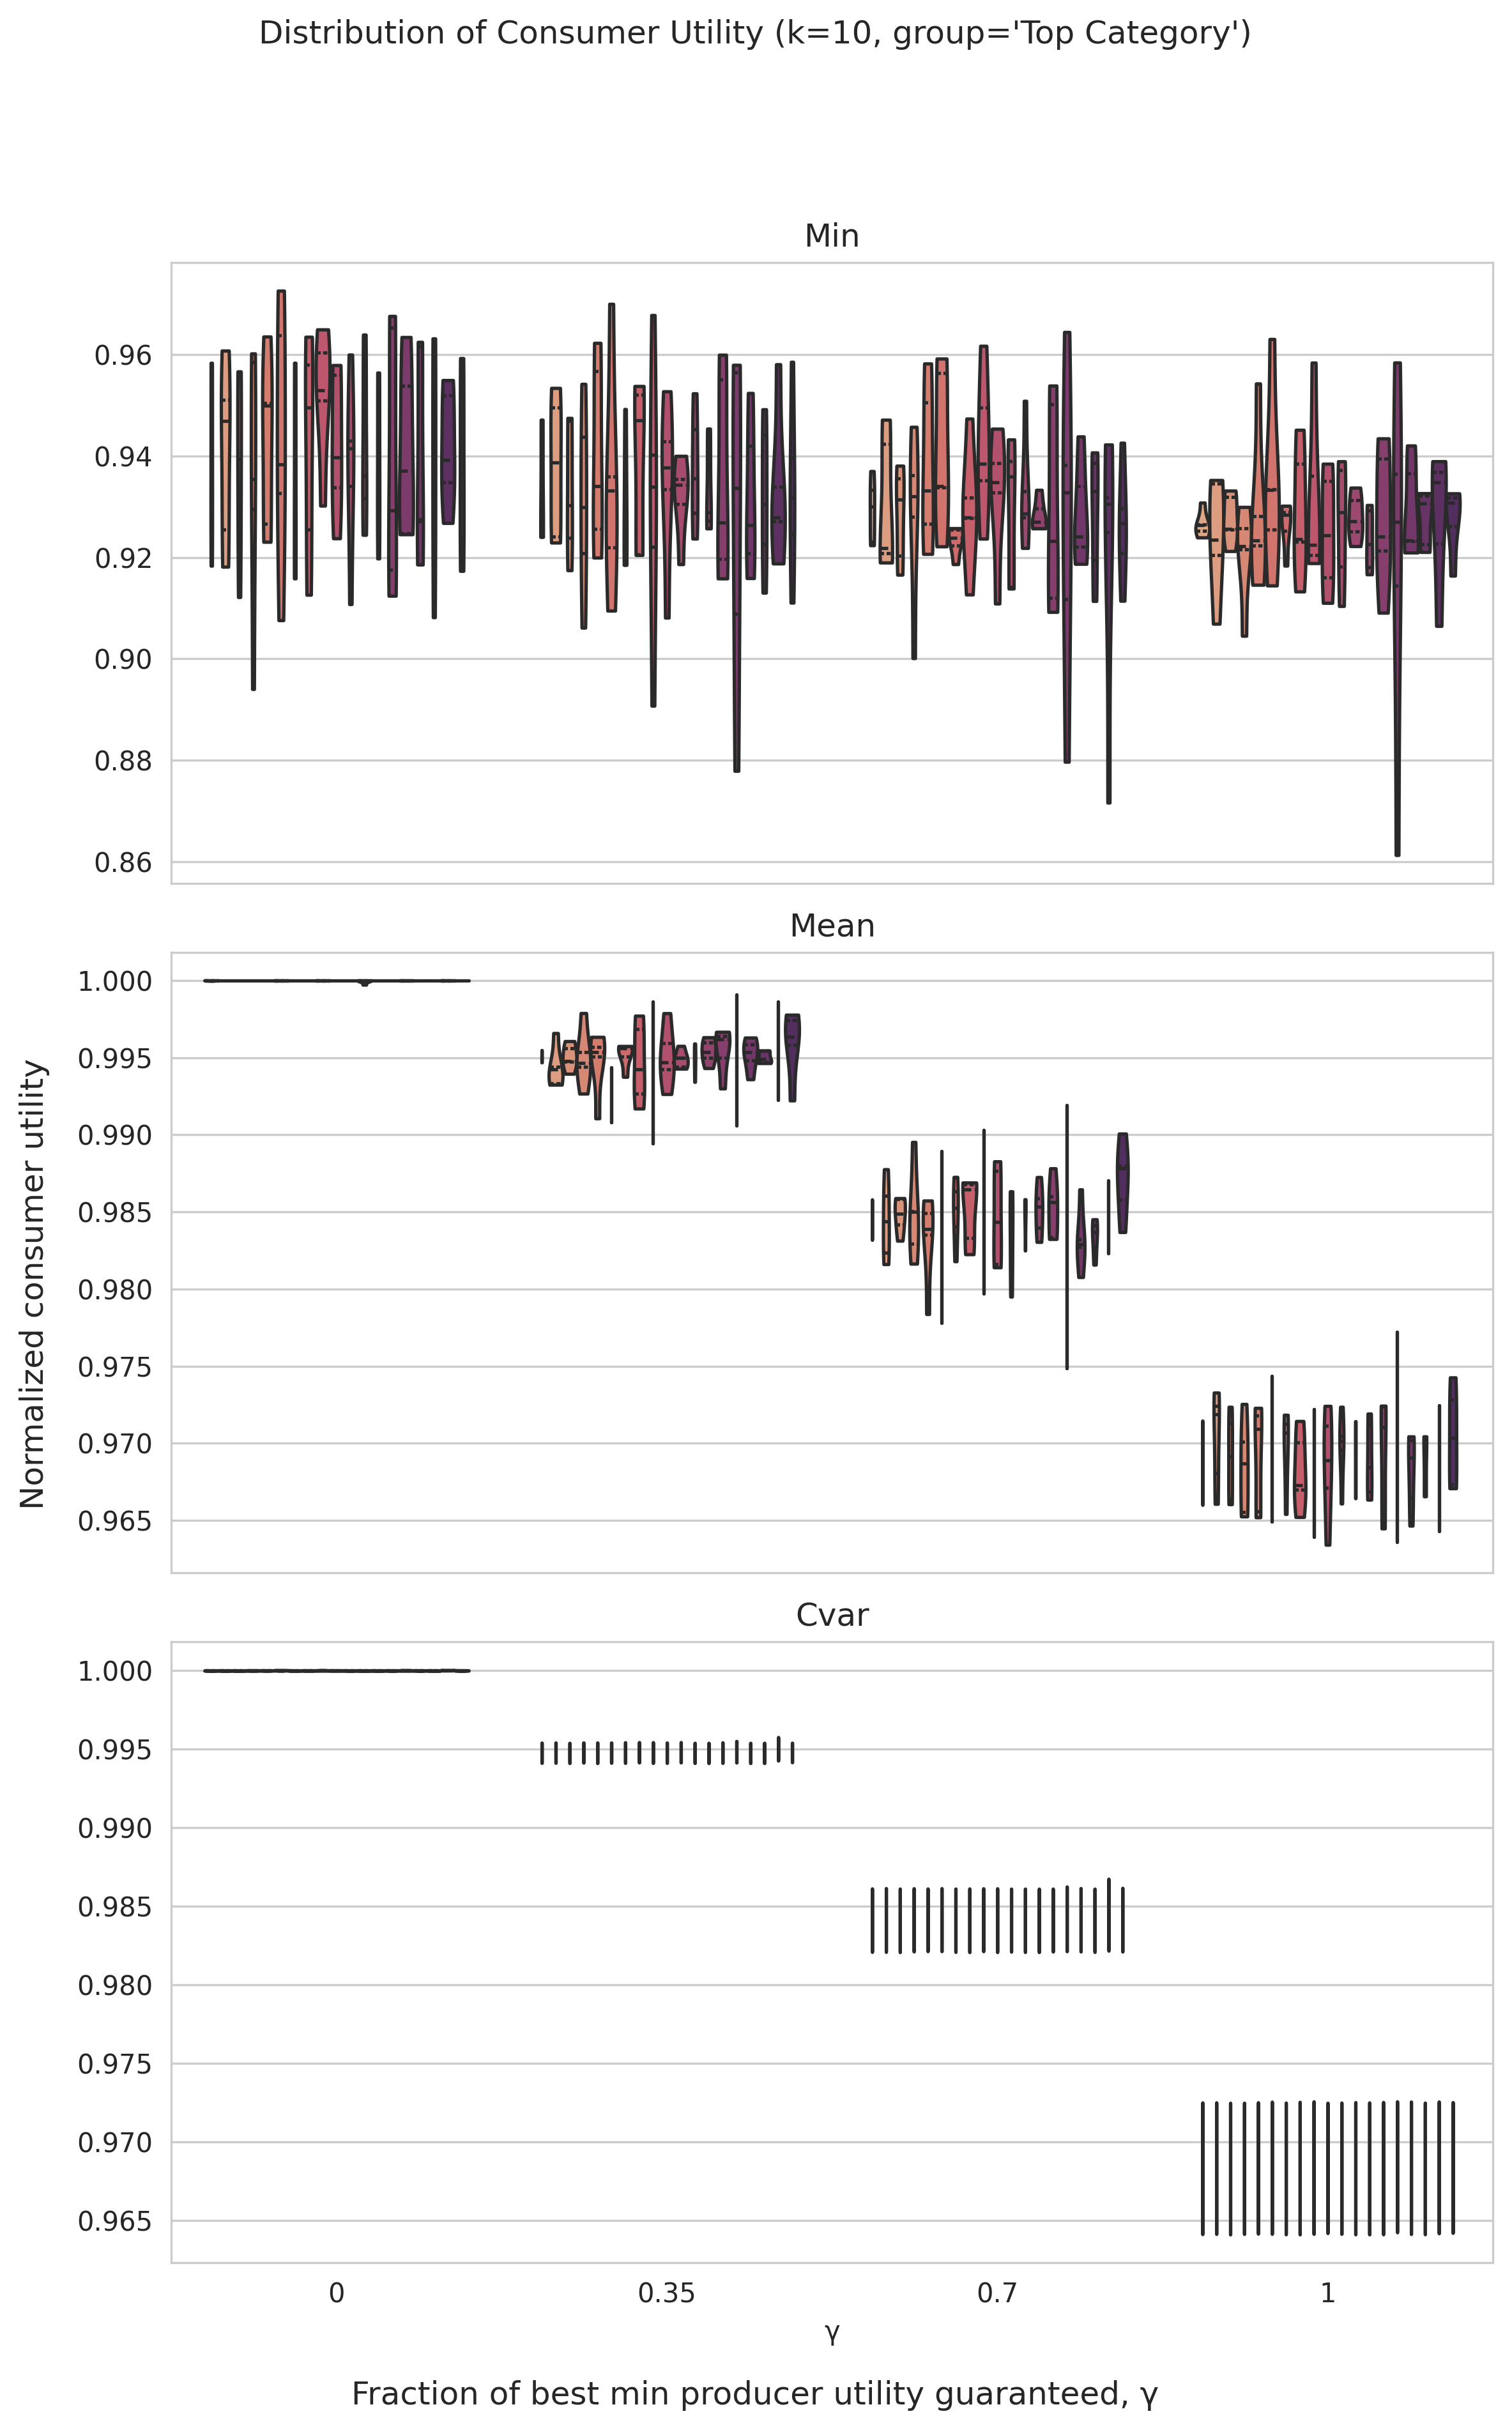

In [125]:
def plot_methods_violins_per_gamma(
    all_results, groups_key, k_rec
):
    sns.set_style("whitegrid")
    n_methods = len(all_results)
    fig, axes = plt.subplots(n_methods, 1,
                             figsize=(8, 4*n_methods), dpi=300,
                             sharex=True)
    if n_methods == 1:
        axes = [axes]

    for ax, (method_name, results) in zip(axes, all_results.items()):
        # gather data
        records = []
        for group_name, group_results in results.items():
            alpha, alpha_results = next(iter(group_results.items()))
            for gamma, runs in sorted(alpha_results.items()):
                for run in runs:
                    records.append({
                        "γ": gamma,
                        "Group": group_name.replace("_", " ").capitalize(),
                        "Utility": np.mean(run),
                    })

        df = pd.DataFrame(records)
        sns.violinplot(
            data=df,
            x="γ",
            y="Utility",
            hue="Group",
            ax=ax,
            cut=0,       # trim tails
            inner="quartile",
            split=False
        )
        ax.set_title(method_name.title())
        ax.legend_.remove()
        # remove y‑axis label
        ax.set_ylabel("")

    # shared labels & legend
    fig.supxlabel(r"Fraction of best min producer utility guaranteed, γ")
    fig.supylabel("Normalized consumer utility")
    handles, labels = axes[-1].get_legend_handles_labels()
    #fig.legend(handles, labels, title="Group",
    #          loc="center left", bbox_to_anchor=(1.02, 0.5))
    fig.suptitle(f"Distribution of Consumer Utility (k={k_rec}, group='{groups_key.replace('_', ' ').title()}')",
                 x=0.5, y=1.05)
    plt.tight_layout()
    plt.show()

plot_methods_violins_per_gamma(
    {
        "Min": min_results["results"]["top_category"],
        "Mean": mean_results["results"]["top_category"],
        "CVar": cvar_results["results"]["top_category"],
    },
    "top_category",
    k_rec=10
)

/scratch-local/73308/ipykernel_474632/2891553788.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


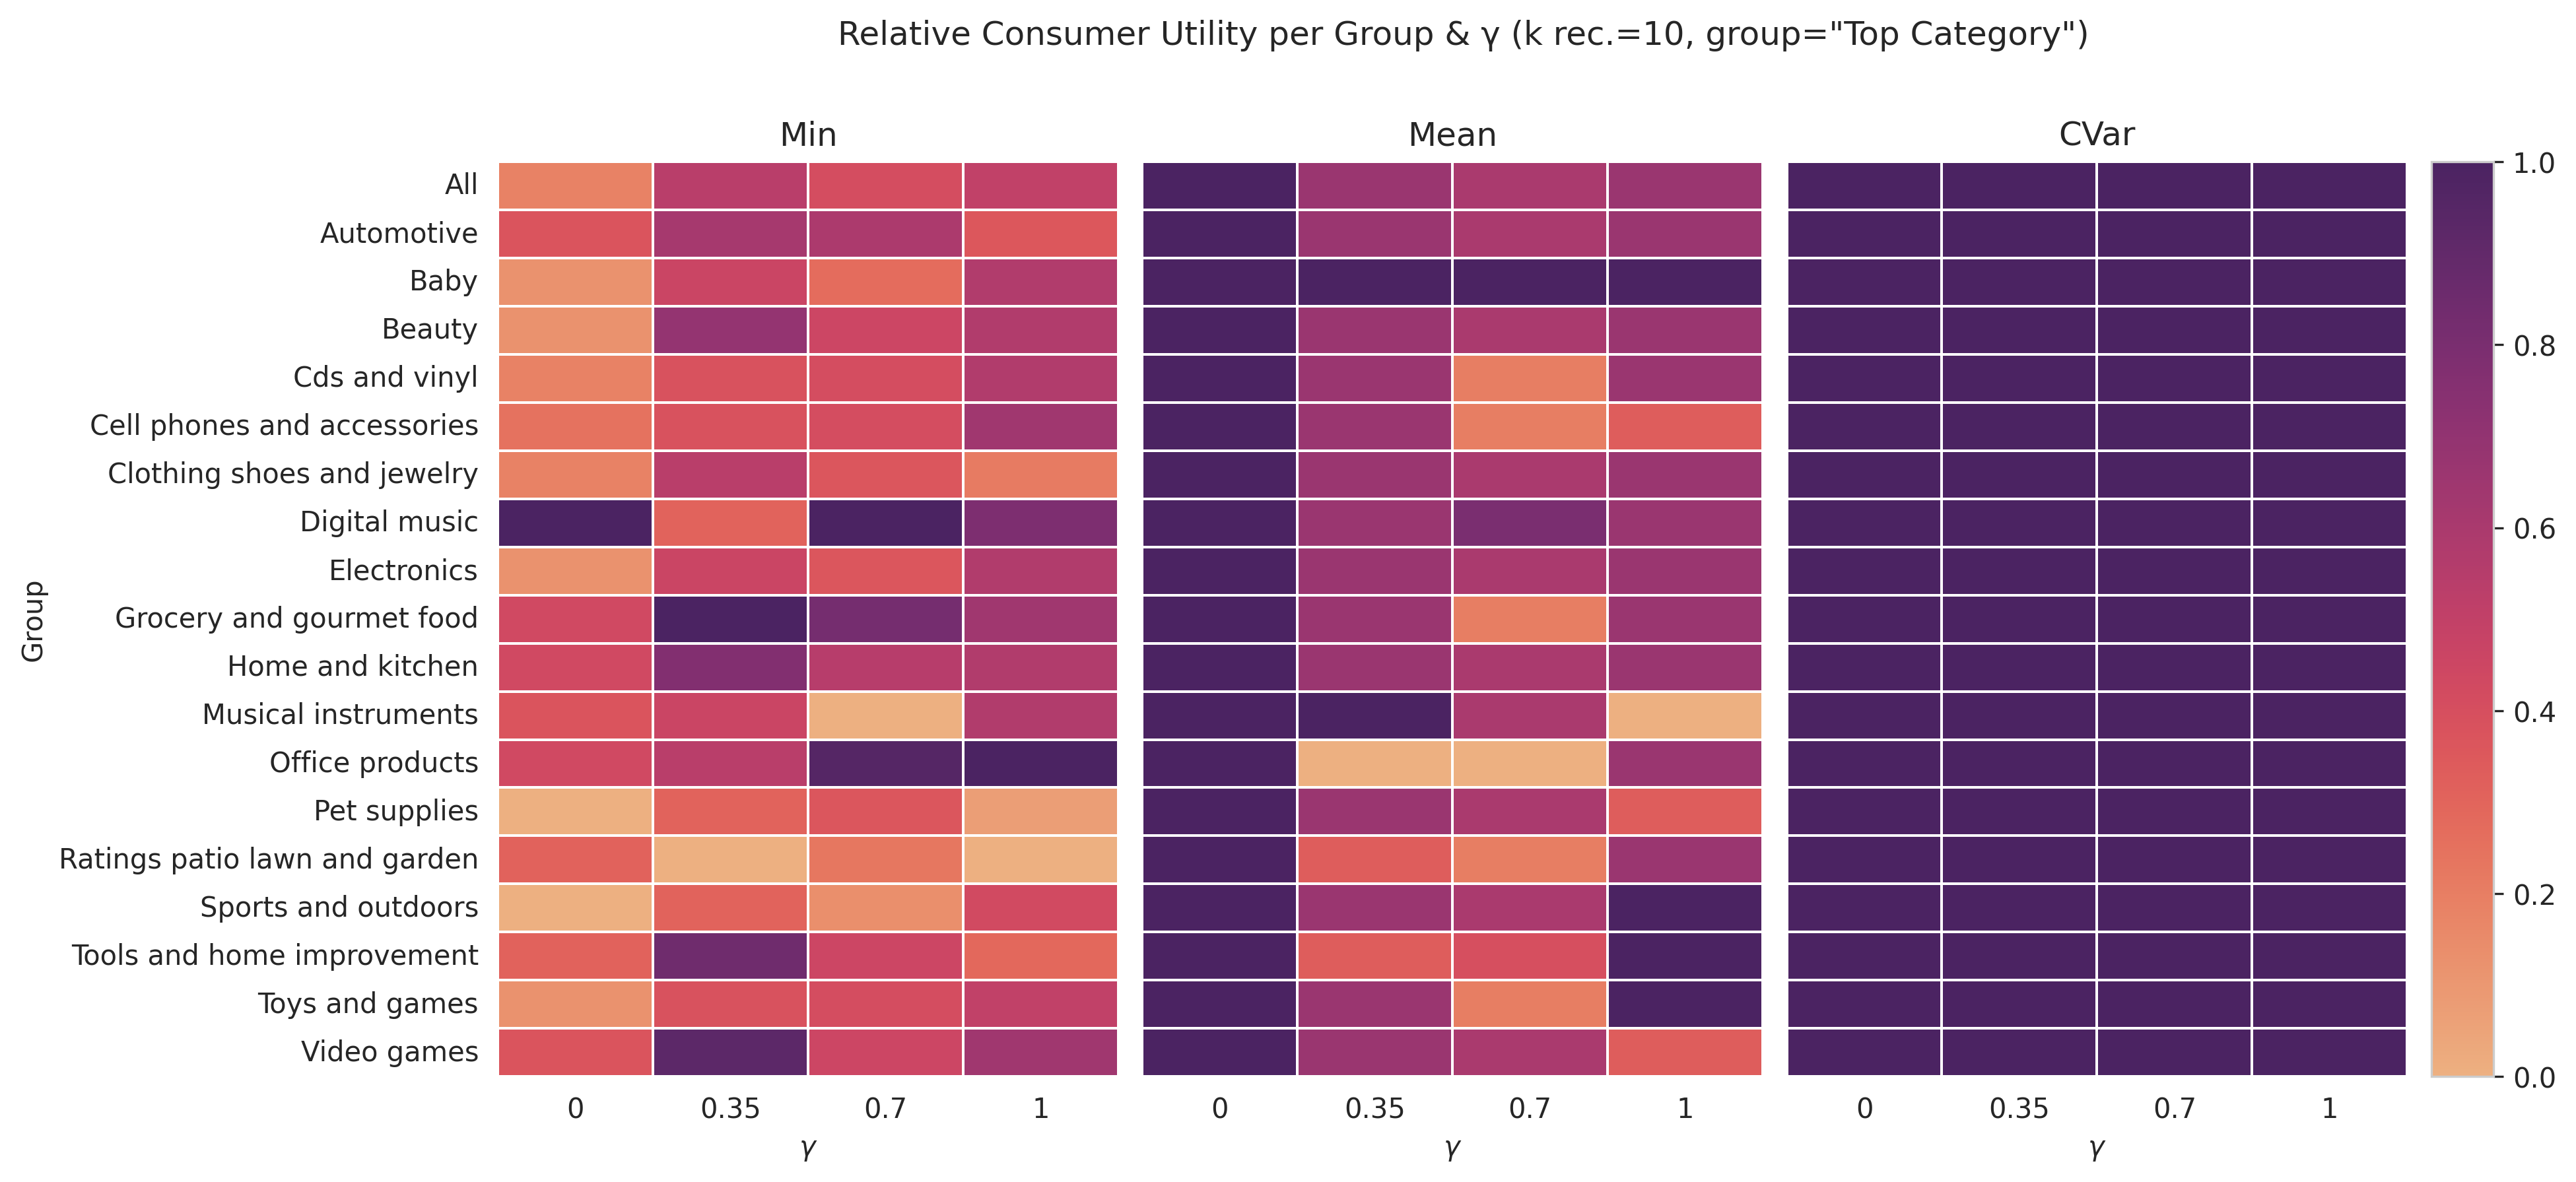

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_methods_heatmap_normalized_per_gamma(
    all_results: dict[str, dict],
    groups_key: str,
    k_rec: int,
) -> None:
    sns.set_style("whitegrid")
    methods = list(all_results.keys())
    n = len(methods)

    # --- normalize per-method, per-gamma as before ---
    def normalize_col(col):
        rng = col.max() - col.min()
        if rng < 1e-8:
            return pd.Series(1.0, index=col.index)
        return (col - col.min()) / rng

    pivots = {}
    for name, results in all_results.items():
        recs = []
        for gname, gres in results.items():
            alpha, ares = next(iter(gres.items()))
            for γ, runs in sorted(ares.items()):
                recs.append({
                    "group": gname.replace("_", " ").capitalize(),
                    "γ": γ,
                    "μ": round(np.mean([np.mean(r) for r in runs]), 3)
                })
        df = pd.DataFrame(recs)
        p = df.pivot(index="group", columns="γ", values="μ")
        pivots[name] = p.apply(normalize_col, axis=0)

    # --- set up GridSpec, sharey on all subplots ---
    fig = plt.figure(figsize=(4*n + 1, 6), dpi=300)
    gs = GridSpec(1, n+1, width_ratios=[1]*n + [0.1], wspace=0.05)

    axs = []
    for i in range(n):
        if i == 0:
            ax = fig.add_subplot(gs[0, i])
        else:
            # share y-axis with the first subplot
            ax = fig.add_subplot(gs[0, i], sharey=axs[0])
        axs.append(ax)
    cax = fig.add_subplot(gs[0, n])  # dedicated colorbar axis

    # --- plot all the heatmaps ---
    for ax, name in zip(axs, methods):
        sns.heatmap(
            pivots[name],
            ax=ax,
            cmap="flare",
            vmin=0, vmax=1,
            cbar=False,
            linewidths=0.5,
            linecolor="white",
        )
        ax.set_title(name)
        ax.set_xlabel(r"$\gamma$")
        # hide y‑ticklabels on every but the first
        if ax is axs[0]:
            ax.set_ylabel("Group")
        else:
            ax.set_ylabel("")
            ax.tick_params(labelleft=False)

    # --- single shared colorbar ---
    mappable = axs[-1].collections[0]
    fig.colorbar(mappable, cax=cax, label="")

    fig.suptitle(
        f"Relative Consumer Utility per Group & γ (k rec.={k_rec}, group=\"{groups_key.replace('_', ' ').title()}\")",
        x=0.5, y=1
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_methods_heatmap_normalized_per_gamma(
    {
        "Min": min_results["results"]["top_category"],
        "Mean": mean_results["results"]["top_category"],
        "CVar": cvar_results["results"]["top_category"],
    },
    "top_category",
    k_rec=10
)